# Full expansion-repression circuit 

This notebook implements a full expansion-repression circuit while varying the diffusion coefficient of the morphogen, the degradation rate for the morphogen, initial morphogen concentration at x = 0 and the initial tissue size.

In [2]:
# Import Python libraries
import numpy as np # numpy is a scientific library
import matplotlib.pyplot as plt # matplotlib is a plotting library


Notebook initialised


In [3]:
# Set global plotting parameters
plt.rcParams['figure.figsize'] = [10, 6]   # Controls default figure size (in inches)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # Controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # Fontsize of the axes title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # Fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # Fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # Fontsize of the tick labels
plt.rc('legend', fontsize = SMALL_SIZE)    # Legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # Fontsize of the figure title

In [4]:
# Define function to plot results
def plot(fig, ax, x, y, L, xLabel = None, yLabel = None, colour='black', figwidth = 10, figlength = 6, linewidth = 4, linestyle='-', linelabel = None):
    fig.set_size_inches(figwidth, figlength, forward = True)
    ax.plot(x, y, linewidth = linewidth, color = colour, linestyle = linestyle,label=linelabel)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_xlim([0, L])
    ax.set_ylim([0,None])
    if linelabel != None:
        ax.legend()
    return fig, ax

In [5]:
# Define system parameters
d = 10            # Diffusion coefficient
k = 10**(-1)           # Degradation rate
c0 = 10          # Pinned concentration at x = 0
L = 100            # Tissue size

# Define simulation parameters
Nx = 201           # Number of spatial (x) gridpoints
tMax = 10000000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

Next we solve the expansion-repression circuit using a simplified model where $\beta$=0, meaning the morphogen cocnentration doesn't repress the expander production. The equations of motion for the morphogen and expander are described by $[M[x,t+h] = D_Md(M[x+h,t]-2M[x,t] + M[x-h,t]) + (1-\alpha)kM[x,t]$ and $[ E[x,t+h] = D_Ed(E[x+h,t]-2E[x,t] + E[x-h,t]) + (1-\alpha)kE[x,t] + \beta_E h(M)$, respectively. Where $\alpha(E)=\frac{\alpha_M}{1+E}$, $D_M(E)=D_M$ and $h(M)=\frac{T_{rep}}{T_{rep}+M}^n$. $T_{rep}$ is a threshold concentration and $n$ is a hill coefficient.

In [6]:
def expander_production_rate(morphogen_concentration):
    """Implemenets the morphogen-expander circuit by interconnecting 
    the parameters governing their independent equations.
    Inputs:
    morphogen_concentration - the amound of morphogen at a time step 
    Ouputs:
    rate - the repression rate of the expander by the morphogen
    """
    B = 10**(-2)
    T = 10**(-3)
    h = 2
    rate = B*(T/(T+morphogen_concentration))**h
    return rate

In [7]:
def Solve_E(d, k, c0, L, Nx, tMax, thresholdSS):
    """ Solves the expansion-repression circuit.
    Inputs:
    d - Diffusion coefficient for the morphogen 
    k - Degradation rate for the morphogen 
    C0 - Pinned concentration at x = 0
    L - Tissue size
    Nx- Number of spatial (x) gridpoints
    tMax - Maximum time
    thresholdSS - Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state (SS)
    const - concentration of the expander 
    Outputs:
    concCurr - concentration of the morphogen at the maximum time or at steady state 
    concCurr_E - concentration of the expander at the maximum time or at steady state
    """
    # Parameters for the expander
    alpha_E = 10**(-5)  # degradation of expander
    D_E = 1  # diffusivity of the expander
    cE_base = 3  # concentration of the expander
    
    B = np.zeros(Nx)

    # Calculate spatial variables
    dx = L / (Nx - 1)  # Spatial grid spacing

    # Define temporal variables
    dt = 1 / (k + ((4 * d) / (dx ** 2)))  # Time step, from the von Neumann stability condition
    Nt = round((tMax / dt) + 1)  # The maximum number of time points
    tCount = 0  # The current timestep

    # Non-dimensionalize variables
    d *= dt / (dx ** 2)
    k *= dt

    # Initialize buffer array to store the concentrations at the previous timestep
    concPrev = np.zeros(Nx)
    concPrev[0] = c0

    # Initialize buffer array for expander concentration
    concPrev_E = np.zeros(Nx)

    # Define flag to indicate when the system has reached steady state (SS)
    flagSS = False


    # Loop over time until the maximum number of time points or until the system reaches steady state (SS)
    while not flagSS and tCount < Nt:
        # Update the timestep counter
        tCount += 1
        
        # Update expander concentration
        concCurr_E = np.zeros(Nx)
        concCurr_E[Nx - 10:Nx] = cE_base
        concCurr_E[1:Nx - 10] = ((1 - (alpha_E * k)) * concPrev_E[1:Nx - 10]) + ((d * D_E) * (concPrev_E[2:Nx-9] + concPrev_E[0:Nx - 11] - (2 * concPrev_E[1:Nx - 10])))+B[1:Nx-10]
        concCurr_E[0] = concCurr_E[1]
        concPrev_E = np.array(concCurr_E)
        
        alpha_M = 1 / (1 + concPrev_E)

        # Update the concentration
        concCurr = np.zeros(Nx)
        concCurr[0] = c0
        concCurr[1:Nx - 1] = ((1 - (alpha_M[1:Nx-1] * k)) * concPrev[1:Nx - 1]) + (d * (concPrev[2:Nx] + concPrev[0:Nx - 2] - (2 * concPrev[1:Nx - 1])))
        concCurr[Nx - 1] = ((1 - (alpha_M[Nx-1] * k)) * concPrev[Nx - 1]) + (2 * d * (concPrev[Nx - 2] - concPrev[Nx - 1]))
        
        B = expander_production_rate(concCurr)
        # Check steady state condition
        delC = np.sum(np.abs(concCurr - concPrev)) / (np.sum(concCurr) * dt)
        if delC < thresholdSS:
            flagSS = True
            print("Steady state reached at t =", tCount * dt, "s")

        # Re-initialize the previous concentration vector ready for the next loop
        concPrev = np.array(concCurr)

    # Output the final concentration
    return concCurr, concCurr_E

In [8]:
def Solve(d, k, c0, L, Nx, tMax, thresholdSS):
    """ Solves the basic system for morphogen diffusion.
    Inputs:
    d - Diffusion coefficient for the morphogen 
    k - Degradation rate for the morphogen 
    C0 - Pinned concentration at x = 0
    L - Tissue size
    Nx- Number of spatial (x) gridpoints
    tMax - Maximum time
    thresholdSS - Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state (SS)
    Outputs:
    concCurr - concentration of the morphogen at the maximum time or at steady state 
    """
    # Calculate spatial variables
    dx = L / (Nx - 1) # Spatial grid spacing

    # Define temporal variables
    dt = 1 / (k + ((4 * d) / (dx ** 2))) # Time step, from the von Neumann stability condition
    Nt = round((tMax / dt) + 1) # The maximum number of time points
    tCount = 0 # The current timestep

    # Non-dimensionalise variables
    d *= dt / (dx ** 2)
    k *= dt

    # Initialise buffer array to store the concentrations at the previous timestep
    concPrev = np.zeros(Nx)
    concPrev[0] = c0

    # Define flag to indicate when system has reached steady state (SS)
    flagSS = 0

    # Loop over time until the maximum number of time points or until the system reaches steady state (SS)
    while flagSS == 0 and tCount < Nt:

        # Update the timestep counter
        tCount += 1

        # Initialise array to store current concentration vector
        concCurr = np.zeros(Nx)

        # Update the equation
        concCurr[0] = c0
        concCurr[1:Nx - 1] = ((1 - k) * concPrev[1:Nx - 1]) + (d * (concPrev[2:Nx] + concPrev[0:Nx - 2] - (2 * concPrev[1: Nx - 1])))
        concCurr[Nx - 1] = ((1 - k) * concPrev[Nx - 1]) + (2 * d * (concPrev[Nx - 2] - concPrev[Nx - 1]))

        # Check steady state condition
        delC = sum(abs(concCurr - concPrev)) / (sum(concCurr) * dt)
        if delC < thresholdSS:
            flagSS = 1
            print("Steady state reached at t =", tCount * dt, "s")

        # Re-initialise the previous concentration vector ready for the next loop
        concPrev = np.array(concCurr)

    # Output the final concentration
    return concCurr

Steady state reached at t = 4528.219862585885 s


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Position/$\\mu m$', ylabel='Conc/$mol \\mu m^{-3}$'>)

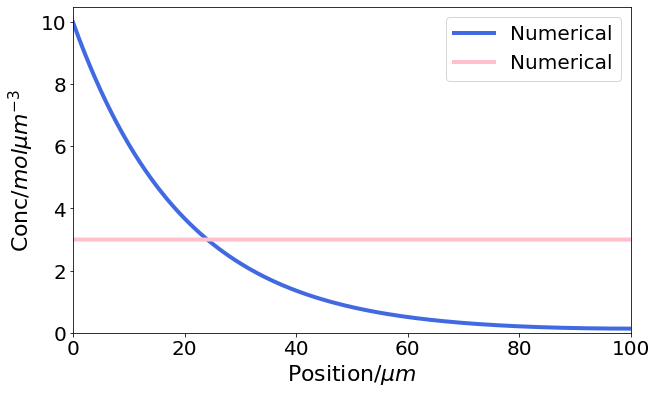

In [9]:
# Calculate decay length
lam = np.sqrt(d / k)

# Define x-axis for plotting
x = np.linspace(0, L, Nx)

# Calculate the steady state concentration
conc_M,conc_E= Solve_E(d, k, c0, L, Nx, tMax, thresholdSS)

# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes
plot(fig, ax, x, conc_M, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'royalblue', linelabel = 'Numerical')
plot(fig, ax, x, conc_E, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'pink', linelabel = 'Numerical')
#plot(fig, ax, x, concAna, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linestyle = '--', linelabel = 'Analytical');

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Position/$\\mu m$', ylabel='Conc/$mol \\mu m^{-3}$'>)

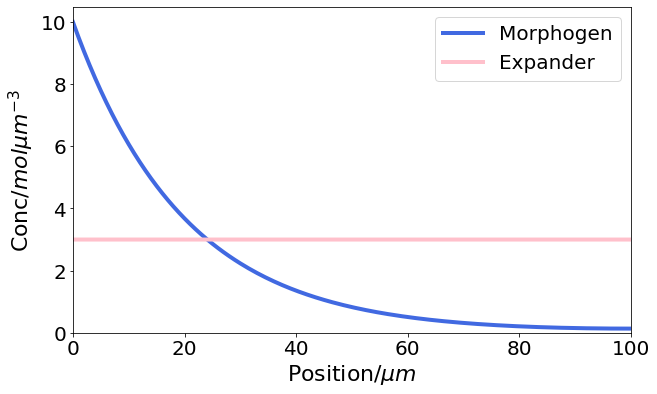

In [10]:
# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes
plot(fig, ax, x, conc_M, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'royalblue', linelabel = 'Morphogen')
plot(fig, ax, x, conc_E, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'pink', linelabel = 'Expander')
#plot(fig, ax, x, concAna, L, xLabel = 'Position/$\mu m$', yLabel = 'Conc/$mol \mu m^{-3}$', colour = 'coral', linestyle = '--', linelabel = 'Analytical');

In [10]:
def findXThresh(cThresh, x, conc):
    """ Extracts the position corresponding to a concentration threshold.
    Inputs:
    cThresh - The threshold concentration
    x -  The position (x-axis) array
    conc - The concentration (y-axis) array
    """
    # Find indexes corresponding to concentrations below cThresh
    cInd = [i for i, val in enumerate(conc) if val < cThresh]

    # Check if any indexes were found
    if(len(cInd) > 0):

        # Extract index corresponding to concentration just below cThresh
        cInd = cInd[0]

        # Use linear interpolation to find concentration at position
        m = (conc[cInd] - conc[cInd - 1]) / (x[cInd] - x[cInd - 1]) # The gradient of the morphogen profile between the two points
        return x[cInd] + ((cThresh - conc[cInd]) / m)

    else:
        print("No concentrations are below the threshold")
        return None

In the following section we increase and decrease each parameter by a certain percentage:
## Section 1 :  Diffusion coefficient for the morphogen
## Section 2 :  Degradation rate for the morphogen 
## Section 3 : Initial morphogen concentration at x = 0
## Section 4 : Initial tissue size 

# Section 1

In [13]:
percentage_change = [5,10,15,20,25,35,40,45,50,55,60,65,70,75,80,85,90]

clean_original = Solve(d, k, c0, L, Nx, tMax, thresholdSS)
clean_circuit,_ =Solve_E(d, k, c0, L, Nx, tMax, thresholdSS)

x = np.linspace(0, L, Nx)

distance_org = findXThresh(5, x, clean_original)
distance_circuit = findXThresh(5, x, clean_circuit)

perc_up_origin = []
perc_up_circuit =[]
perc_down_origin =[]
perc_down_circuit = []

for i in percentage_change:
    plus = (100+i)/100
    minus = (100-i)/100
    
    d_plus = d*plus
    d_minus = d*minus 
    
    new_original_plus = Solve(d_plus, k, c0, L, Nx, tMax, thresholdSS)
    new_circuit_plus,_ =Solve_E(d_plus, k, c0, L, Nx, tMax, thresholdSS)
    
    new_original_minus = Solve(d_minus, k, c0, L, Nx, tMax, thresholdSS)
    new_circuit_minus,_ =Solve_E(d_minus, k, c0, L, Nx, tMax, thresholdSS)
    
    distance_new_org_plus = findXThresh(5, x, new_original_plus)
    distance_new_circuit_plus = findXThresh(5, x,new_circuit_plus)

    distance_new_org_minus= findXThresh(5, x, new_original_minus)
    distance_new_circuit_minus = findXThresh(5, x,new_circuit_minus)
    
    perc_up_org = ((distance_new_org_plus-distance_org)/distance_org)*100
    perc_up_new = ((distance_new_circuit_plus-distance_circuit)/distance_circuit)*100
    
    perc_down_org = ((distance_new_org_minus-distance_org)/distance_org)*100
    perc_down_new =((distance_new_circuit_minus-distance_circuit)/distance_circuit)*100
    
    perc_up_origin.append(perc_up_org)
    perc_up_circuit.append(perc_up_new)
    perc_down_origin.append(perc_down_org)
    perc_down_circuit.append(perc_down_new)

Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4528.219862585885 s
Steady state reached at t = 141.9214753123141 s
Steady state reached at t = 4328.697204045212 s
Steady state reached at t = 141.91321499013807 s
Steady state reached at t = 4747.560815253123 s
Steady state reached at t = 141.91936399772857 s
Steady state reached at t = 4146.450880181715 s
Steady state reached at t = 141.9083969465649 s
Steady state reached at t = 4989.757113115892 s
Steady state reached at t = 141.91743617599133 s
Steady state reached at t = 3979.326453014666 s
Steady state reached at t = 141.90301249081557 s
Steady state reached at t = 5258.457016899339 s
Steady state reached at t = 141.9104633003644 s
Steady state reached at t = 3825.5283706402915 s
Steady state reached at t = 141.88914910226384 s
Steady state reached at t = 5558.024980483997 s
Steady state reached at t = 141.904047976012 s
Steady state reached at t = 3683.5182408795604 s
Steady state reached at t = 141.8

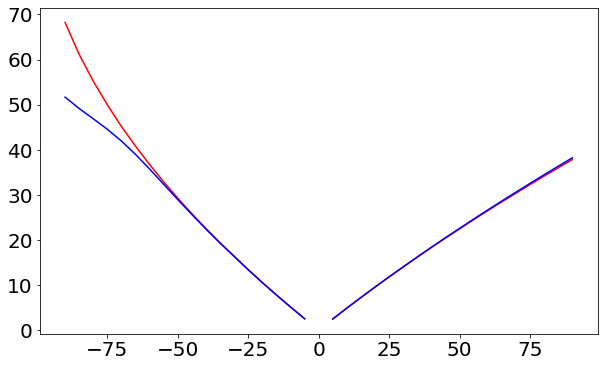

In [20]:
not_minus_org = -1*np.array(perc_down_origin)
not_minus_circuit = -1*np.array(perc_down_circuit)

neg_percentage_change = -1*np.array(percentage_change)


plt.plot(neg_percentage_change,not_minus_org,color='red')
plt.plot(neg_percentage_change,not_minus_circuit,color='blue')
plt.plot(percentage_change,perc_up_origin,color='red')
plt.plot(percentage_change,perc_up_circuit,color='blue')


# Section 2

In [21]:
percentage_change = [5,10,15,20,25,35,40,45,50,55,60,65,70,75,80,85,90]

clean_original = Solve(d, k, c0, L, Nx, tMax, thresholdSS)
clean_circuit,_ =Solve_E(d, k, c0, L, Nx, tMax, thresholdSS)

x = np.linspace(0, L, Nx)

distance_org = findXThresh(5, x, clean_original)
distance_circuit = findXThresh(5, x, clean_circuit)

perc_up_origin = []
perc_up_circuit =[]
perc_down_origin =[]
perc_down_circuit = []

for i in percentage_change:
    plus = (100+i)/100
    minus = (100-i)/100
    
    d_plus = k*plus
    d_minus = k*minus 
    
    new_original_plus = Solve(d,d_plus, c0, L, Nx, tMax, thresholdSS)
    new_circuit_plus,_ =Solve_E(d,d_plus,c0, L, Nx, tMax, thresholdSS)
    
    new_original_minus = Solve(d,d_minus, c0, L, Nx, tMax, thresholdSS)
    new_circuit_minus,_ =Solve_E(d,d_minus, c0, L, Nx, tMax, thresholdSS)
    
    distance_new_org_plus = findXThresh(5, x, new_original_plus)
    distance_new_circuit_plus = findXThresh(5, x,new_circuit_plus)

    distance_new_org_minus= findXThresh(5, x, new_original_minus)
    distance_new_circuit_minus = findXThresh(5, x,new_circuit_minus)
    
    perc_up_org = ((distance_new_org_plus-distance_org)/distance_org)*100
    perc_up_new = ((distance_new_circuit_plus-distance_circuit)/distance_circuit)*100
    
    perc_down_org = ((distance_new_org_minus-distance_org)/distance_org)*100
    perc_down_new =((distance_new_circuit_minus-distance_circuit)/distance_circuit)*100
    
    perc_up_origin.append(perc_up_org)
    perc_up_circuit.append(perc_up_new)
    perc_down_origin.append(perc_down_org)
    perc_down_circuit.append(perc_down_new)

Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4528.219862585885 s
Steady state reached at t = 135.60475937665908 s
Steady state reached at t = 4528.965366478249 s
Steady state reached at t = 148.8678597082982 s
Steady state reached at t = 4527.168243855211 s
Steady state reached at t = 129.84822934232713 s
Steady state reached at t = 4529.3735556804695 s
Steady state reached at t = 156.5619339121744 s
Steady state reached at t = 4525.835467549503 s
Steady state reached at t = 124.56671767167347 s
Steady state reached at t = 4529.394497704774 s
Steady state reached at t = 165.11853078052286 s
Steady state reached at t = 4524.246494050036 s
Steady state reached at t = 119.71646265301024 s
Steady state reached at t = 4528.984511616288 s
Steady state reached at t = 174.69390304847576 s
Steady state reached at t = 4522.426286856571 s
Steady state reached at t = 115.23497267759562 s
Steady state reached at t = 4528.087431693989 s
Steady state reached at t = 185

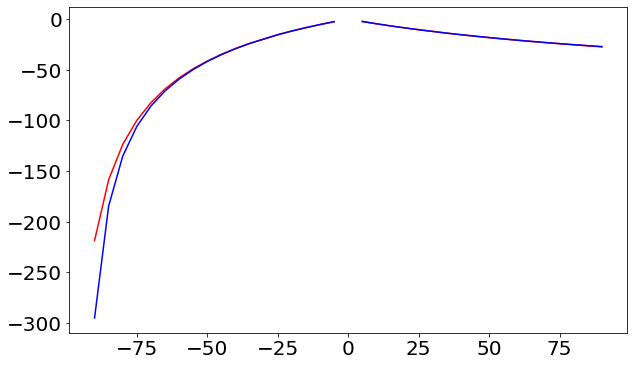

In [24]:
not_minus_org = -1*np.array(perc_down_origin)
not_minus_circuit = -1*np.array(perc_down_circuit)

neg_percentage_change = -1*np.array(percentage_change)


plt.plot(neg_percentage_change,not_minus_org,color='red')
plt.plot(neg_percentage_change,not_minus_circuit,color='blue')
plt.plot(percentage_change,perc_up_origin,color='red')
plt.plot(percentage_change,perc_up_circuit,color='blue')

# Section 3

In [26]:
percentage_change = [5,10,15,20,25,35,40,45,50,55,60,65,70,75,80,85,90]

clean_original = Solve(d, k, c0, L, Nx, tMax, thresholdSS)
clean_circuit,_ =Solve_E(d, k, c0, L, Nx, tMax, thresholdSS)

x = np.linspace(0, L, Nx)

distance_org = findXThresh(5, x, clean_original)
distance_circuit = findXThresh(5, x, clean_circuit)

perc_up_origin = []
perc_up_circuit =[]
perc_down_origin =[]
perc_down_circuit = []

for i in percentage_change:
    plus = (100+i)/100
    minus = (100-i)/100
    
    d_plus = c0*plus
    d_minus = c0*minus 
    
    new_original_plus = Solve(d,k,d_plus, L, Nx, tMax, thresholdSS)
    new_circuit_plus,_ =Solve_E(d,k,d_plus, L, Nx, tMax, thresholdSS)
    
    new_original_minus = Solve(d,k,d_minus, L, Nx, tMax, thresholdSS)
    new_circuit_minus,_ =Solve_E(d,k,d_minus, L, Nx, tMax, thresholdSS)
    
    distance_new_org_plus = findXThresh(5, x, new_original_plus)
    distance_new_circuit_plus = findXThresh(5, x,new_circuit_plus)

    distance_new_org_minus= findXThresh(5, x, new_original_minus)
    distance_new_circuit_minus = findXThresh(5, x,new_circuit_minus)
    
    perc_up_org = ((distance_new_org_plus-distance_org)/distance_org)*100
    perc_up_new = ((distance_new_circuit_plus-distance_circuit)/distance_circuit)*100
    
    perc_down_org = ((distance_new_org_minus-distance_org)/distance_org)*100
    perc_down_new =((distance_new_circuit_minus-distance_circuit)/distance_circuit)*100
    
    perc_up_origin.append(perc_up_org)
    perc_up_circuit.append(perc_up_new)
    perc_down_origin.append(perc_down_org)
    perc_down_circuit.append(perc_down_new)

Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4528.219862585885 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4525.346658338539 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4531.199250468458 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4522.567145534042 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4534.278575890069 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4519.887570268583 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4537.470331043099 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4517.301686445971 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4540.762023735166 s
Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4514.797001873829 s
Steady state reached at t = 14

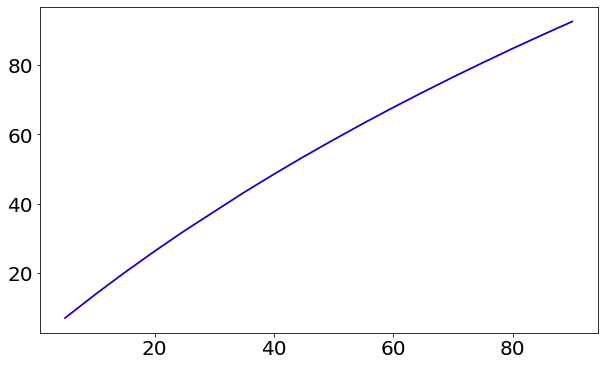

In [28]:
not_minus_org = -1*np.array(perc_down_origin)
not_minus_circuit = -1*np.array(perc_down_circuit)

neg_percentage_change = -1*np.array(percentage_change)


#plt.plot(neg_percentage_change,not_minus_org,color='red')
#plt.plot(neg_percentage_change,not_minus_circuit,color='blue')
plt.plot(percentage_change,perc_up_origin,color='red')
plt.plot(percentage_change,perc_up_circuit,color='blue')

# Section 4

In [13]:
percentage_change = [5,10,15,20,25,35,40,45,50,55,60,65,70,75,80,85,90]

clean_original = Solve(d, k, c0, L, Nx, tMax, thresholdSS)
clean_circuit,_ =Solve_E(d, k, c0, L, Nx, tMax, thresholdSS)

x = np.linspace(0, L, Nx)

distance_org = findXThresh(5, x, clean_original)
distance_circuit = findXThresh(5, x, clean_circuit)

perc_up_origin = []
perc_up_circuit =[]
perc_down_origin =[]
perc_down_circuit = []

for i in percentage_change:
    print(i)
    plus = (100+i)/100
    minus = (100-i)/100
    
    d_plus = L*plus
    d_minus = L*minus 
    
    new_original_plus = Solve(d,k,c0,d_plus, Nx, tMax, thresholdSS)
    new_circuit_plus,_ =Solve_E(d,k,c0,d_plus, Nx, tMax, thresholdSS)
    
    new_original_minus = Solve(d,k,c0,d_minus, Nx, tMax, thresholdSS)
    new_circuit_minus,_ =Solve_E(d,k,c0,d_minus, Nx, tMax, thresholdSS)
    
    distance_new_org_plus = findXThresh(5, x, new_original_plus)
    distance_new_circuit_plus = findXThresh(5, x,new_circuit_plus)

    distance_new_org_minus= findXThresh(5, x, new_original_minus)
    distance_new_circuit_minus = findXThresh(5, x,new_circuit_minus)
    
    perc_up_org = ((distance_new_org_plus-distance_org)/distance_org)*100
    perc_up_new = ((distance_new_circuit_plus-distance_circuit)/distance_circuit)*100
    
    perc_down_org = ((distance_new_org_minus-distance_org)/distance_org)*100
    perc_down_new =((distance_new_circuit_minus-distance_circuit)/distance_circuit)*100
    
    perc_up_origin.append(perc_up_org)
    perc_up_circuit.append(perc_up_new)
    perc_down_origin.append(perc_down_org)
    perc_down_circuit.append(perc_down_new)

Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4528.219862585885 s
5
Steady state reached at t = 141.91110500420805 s
Steady state reached at t = 4954.197997942043 s
Steady state reached at t = 141.91704366755624 s
Steady state reached at t = 4118.627211838322 s
10
Steady state reached at t = 141.89375534751846 s
Steady state reached at t = 5395.438824389056 s
Steady state reached at t = 141.90597260137056 s
Steady state reached at t = 3726.174061881173 s
15
Steady state reached at t = 141.8779009225187 s
Steady state reached at t = 5850.23560213511 s
Steady state reached at t = 141.8665477620262 s
Steady state reached at t = 3351.3878732884677 s
20
Steady state reached at t = 141.85632930362675 s
Steady state reached at t = 6315.942651613548 s
Steady state reached at t = 141.79128348660538 s
Steady state reached at t = 2994.6701319472218 s
25
Steady state reached at t = 141.8439024390244 s
Steady state reached at t = 6788.487804878048 s
Steady state reach

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

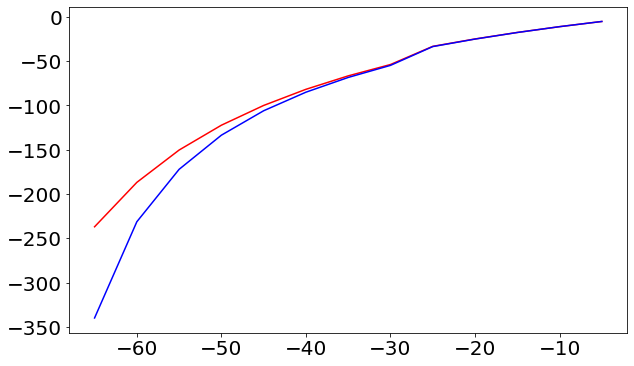

In [17]:
percentage_change = [5,10,15,20,25,30,35,40,45,50,55,60,65]
not_minus_org = -1*np.array(perc_down_origin)
not_minus_circuit = -1*np.array(perc_down_circuit)

neg_percentage_change = -1*np.array(percentage_change)


plt.plot(neg_percentage_change,not_minus_org,color='red')
plt.plot(neg_percentage_change,not_minus_circuit,color='blue')
#plt.plot(percentage_change,perc_up_origin,color='red')
#plt.plot(percentage_change,perc_up_circuit,color='blue')